## 图像工程概论期末大作业
#### 学号:2018218038 姓名:陈飞鸿 班级:18-电信科-三班
#### 内容:基于智能缩放算法Seam Carving的图像处理
#### 环境:python3.8 vscode-jupternotebook 
#### 核心库:open-cv numpy matplotlib
#### 辅助库:tqdm numba

### step 1 导入相关库


In [63]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# used to show progress
from tqdm import tqdm
# to call GPU
from numba import jit
# to get convolve
from scipy.ndimage.filters import convolve

### step 2 读取图片

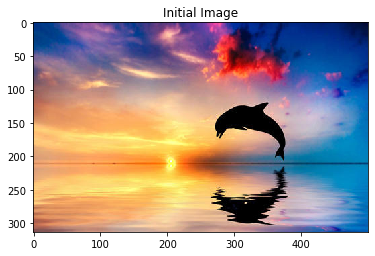

In [64]:
image_rgb = cv2.imread('./images/before/dolphin.jpg')
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Initial Image')
plt.ion()

### Step 3 利用局部梯度法计算能量

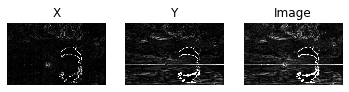

In [65]:
# 调用sobel算子实现梯度图
# 转成灰度图方便处理

image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
x = cv2.Sobel(image_gray, cv2.CV_16S, 1, 0)
y = cv2.Sobel(image_gray, cv2.CV_16S, 0, 1)

absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
 
dst = cv2.addWeighted(absX, 1, absY, 1, 0)
plt.subplot(1,3,1), plt.imshow(absX,'gray'), plt.title('X'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(absY,'gray'), plt.title('Y'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(dst,'gray'), plt.title('Image'), plt.axis('off')
plt.ion()

#### 能量函数 局部梯度法

#### 动态规划求解最优Seam

In [66]:
@jit
def backward_energy(img,arg=1):
    '''
    function:get forward energy
    args:img arg(1, 2, 3)
    '''

    sobel_x = np.array([
        [-1.0, -2.0, -1.0],
        [0.0, 0.0, 0.0],
        [1.0, 2.0, 1.0],
    ])
    # RGB三个通道分别进行卷积操作
    sobel_x_3D = np.stack([sobel_x] * 3, axis=2)

    sobel_y = np.array([
        [-1.0, 0.0, 1.0],
        [-2.0, 0.0, 2.0],
        [-1.0, 0.0, 1.0],
    ])
    # RGB三个通道分别进行卷积操作
    sobel_y_3D = np.stack([sobel_y] * 3, axis=2)

    img = img.astype('float32')

    # 一范数
    if arg == 1:
        convolved = np.absolute(convolve(img, sobel_x_3D)) + np.absolute(convolve(img, sobel_y_3D))
    # 二范数
    elif arg == 2:
        convolved = np.sqrt((convolve(img, sobel_x_3D))**2 + (convolve(img, sobel_y_3D)**2))
    # 无穷范数
    elif arg == 3:
        convolved = np.maximum(np.absolute(convolve(img, sobel_x_3D)), np.absolute(convolve(img, sobel_y_3D)))

    # 计算RGB三个通道的能量值之和
    energy = convolved.sum(axis=2)
    return energy

In [67]:
@jit
def forward_energy(img):
    """
    Forward energy defined in "Improved Seam Carving for Video Retargeting" by Rubinstein, Shamir, Avidan.
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64)
    energy = np.zeros(img.shape[:2])
    m = np.zeros_like(energy)

    U = np.roll(img, 1, axis=0)  # i - 1
    L = np.roll(img, 1, axis=1)  # j - 1
    R = np.roll(img, -1, axis=1)  # j + 1

    cU = np.abs(R - L)
    cR = cU + np.abs(U - R)
    cL = cU + np.abs(U - L)

    # dp
    for i in range(1, img.shape[0]):
        mU = m[i - 1]  # M(i-1, j)
        mL = np.roll(mU, 1)  # M(i-1, j-1)
        mR = np.roll(mU, -1)  # M(i-1, j+1)

        m_all = np.array([mU, mL, mR])
        c_all = np.array([cU[i], cL[i], cR[i]])
        m_all += c_all

        argmins = fast_argmin_axis_0(m_all)
        m[i] = np.choose(argmins, m_all)
        energy[i] = np.choose(argmins, c_all)

    return energy

In [68]:
@jit
def fast_argmin_axis_0(a):
    matches = np.nonzero((a == np.min(a, axis=0)).ravel())[0]
    rows, cols = np.unravel_index(matches, a.shape)
    argmin_array = np.empty(a.shape[1], dtype=np.intp)
    argmin_array[cols] = rows
    return argmin_array

@jit
def get_min_seam(img, protect_mask=None, remove_mask=None):
    h, w = img.shape[:2]
    # call function to get energy
    M = forward_energy(img)
    if protect_mask is not None:
        M[np.where(protect_mask > MASK_THRES)] = PROTECT_MASK_ENERGY
    if remove_mask is not None:
        M[np.where(remove_mask > MASK_THRES)] = -100 * PROTECT_MASK_ENERGY

    dp = np.zeros_like(M, dtype=np.int32)
    for i in range(1, h):
        for j in range(0, w):
            left = max(j - 1, 0)
            idx = np.argmin(M[i - 1, left: j + 2])
            dp[i, j] = idx + left
            M[i, j] += M[i - 1, idx + left]

    seam_idx = []
    j = np.argmin(M[-1])
    for i in range(h - 1, -1, -1):
        seam_idx.append(j)
        j = dp[i, j]

    seam_idx.reverse()
    return np.array(seam_idx)

#### 对seam进行操作

In [69]:
@jit
def manip_seam(img, delta, mask=None):
    seams = []
    temp_img = img.copy()
    temp_mask = mask.copy() if mask is not None else None
    last_seam = None
    for _ in tqdm(range(abs(delta))):
        seam_idx = get_min_seam(temp_img, temp_mask)
        temp_img = _remove_seam_impl(temp_img, seam_idx)
        if temp_mask is not None:
            temp_mask = _remove_seam_impl(temp_mask, seam_idx)
        if last_seam is not None:
            seam_idx[seam_idx > last_seam] += 1
        last_seam = seam_idx
        seams.append(last_seam)

    if delta < 0:
        return temp_img, temp_mask, seams
    else:
        seams.reverse()

        for i in tqdm(range(delta)):
            seam = seams[i]
            img = _add_seam_impl(img, seam)
            if mask is not None:
                mask = _add_seam_impl(mask, seam)
            for j in range(delta):
                seams[j][np.where(seams[j] > seam)] += 1
        return img, mask, seams

#### Object removal

In [ ]:
def object_removal(img, remove_mask, protect_mask=None):
    h, w = img.shape[:2]
    output = img
    last = -1
    while True:
        remain = len(np.where(remove_mask > MASK_THRES)[0])
        if remain == last:
            break
        last = remain
        print("Remaining: {}".format(remain))
        if remain == 0:
            break
        seam_idx = get_min_seam(output, protect_mask, remove_mask)
        output = _remove_seam_impl(output, seam_idx)
        remove_mask = _remove_seam_impl(remove_mask, seam_idx)
        if protect_mask is not None:
            protect_mask = _remove_seam_impl(protect_mask, seam_idx)
    cv2.waitKey()
    num_enlarge = (h if remove_horiz else w) - output.shape[1]
    print("Start to restore")
    output, _, __ = manip_seam(output, num_enlarge, protect_mask)
    print("Done")
    return output

#### 移除seam 实现图像缩小

In [70]:
@jit
def _remove_seam_impl(img, seam_idx):
    h, w = img.shape[:2]
    bin_mask = np.ones((h, w), dtype=np.int32)
    bin_mask[np.arange(h), seam_idx] = 0
    new_shape = list(img.shape)
    new_shape[1] -= 1
    if len(img.shape) == 3:
        bin_mask = np.stack([bin_mask] * 3, axis=2)
    return img[bin_mask > 0].reshape(new_shape)

#### 增添seam 实现图像放大

In [71]:
@jit
def _add_seam_impl(img, seam_idx):
    new_shape = list(img.shape)
    new_shape[1] += 1
    output = np.zeros(new_shape)
    h, w = img.shape[:2]
    for row in range(h):
        col = seam_idx[row]
        left = max(col - 1, 0)
        output[row, :col] = img[row, :col]
        output[row, col] = np.average(img[row, left: col + 2], axis=0)
        output[row, col + 1:] = img[row, col:]
    return np.round(output).astype(np.uint8)

#### 旋转图像以便对行列进行操作

In [72]:
def rotate_image(img, cw):
    return np.rot90(img, 1 if cw else 3)

#### seam可视化

In [73]:
def visualize_seam(img, seam_idxs, rotate, alpha=0.5):
    img = img.astype(np.float64)
    if rotate:
        img = rotate_image(img, True)
    rows = range(img.shape[0])
    for seam in seam_idxs:
        img[rows, seam] *= (1 - alpha)
        img[rows, seam] += alpha * np.array([0., 255., 255.])
    img = np.round(img).astype(np.uint8)
    if rotate:
        img = rotate_image(img, False)
    return img

#### seam carve

In [74]:
def seam_carve(img, dx, dy, mask=None, vis=True):
    h, w = img.shape[:2]
    assert w + dx > 0 and h + dy > 0 and dx < w and dy < h
    if mask is not None:
        m_h, m_w = mask.shape[:2]
        assert h == m_h and w == m_w
    output = img.copy()
    seams_x = None
    seams_y = None
    if dx != 0:
        output_x, mask, seams_x = manip_seam(output, dx, mask)
    else:
        output_x = output
    if dy != 0:
        output = rotate_image(output_x, True)
        if mask is not None:
            mask = rotate_image(mask, True)
        output, mask, seams_y = manip_seam(output, dy, mask)
        output = rotate_image(output, False)
    else:
        output = output_x
    if vis:
        if seams_x is not None:
            vis_dst = output_x if dx > 0 else img
            vis_dst = visualize_seam(vis_dst, seams_x, False)
            cv2.imwrite('seams_x.jpg', vis_dst)
            cv2.waitKey(1)
        if seams_y is not None:
            vis_dst = output if dy > 0 else output_x
            vis_dst = visualize_seam(vis_dst, seams_y, True)
            cv2.imwrite('seams_y.jpg', vis_dst)
            cv2.waitKey(1)
    return output

#### 结果测试

In [75]:
MASK_THRES = 240.
PROTECT_MASK_ENERGY = 1E6

100%|██████████| 100/100 [00:06<00:00, 15.86it/s]
(213, 400, 3)


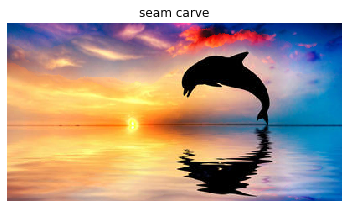

In [77]:
mask = cv2.imread('./images/mask/dolphin-mask.png',0)
output = seam_carve(image_rgb, -100, -100, mask)
plt.figure(),plt.title('seam carve'),plt.axis('off')
print(output.shape)
plt.imshow(output)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
cv2.imwrite('./images/before/dolphin.jpg', output)
plt.ion()